In [415]:
%%capture
! pip install stable-baselines3

In [416]:
import math
import random
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

<h2>Use CUDA</h2>

In [418]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Create Environments</h2>

In [419]:
samples = [[-0.6810, -0.7323, -0.3519],
        [ 0.9754, -0.2205, -0.9598],
        [ 0.8309, -0.5564, -0.8232],
        [ 0.4757,  0.8796,  0.8216],
        [-0.9221, -0.3869,  0.8180],
        [-0.9108, -0.4129,  0.2524],
        [-0.1120, -0.9937, -0.8391],
        [ 0.5760,  0.8175,  0.6597],
        [ 0.4632, -0.8863, -0.1590],
        [ 0.5347,  0.8450, -0.4712],
        [ 0.5242,  0.8516, -0.9269],
        [-0.8494, -0.5277,  0.9623],
        [ 0.8243, -0.5661, -0.8888],
        [-0.9457, -0.3252, -0.5394],
        [ 0.9998, -0.0188, -0.7901],
        [-0.9918, -0.1282,  0.9201]]

num_envs = 16

env1_name = "Pendulum-v1"
env2_name = "MountainCarContinuous-v0"

env1 = gym.make(env1_name)
env2 = gym.make(env2_name)

envs1 = make_vec_env(env1_name, n_envs=num_envs)
envs2 = make_vec_env(env2_name, n_envs=num_envs)

p_envs_ids = [env1_name, env2_name ]
p_envs = [env1, env2]

<h2>Neural Network</h2>

In [420]:
class RBFFeatureEncoder:
    def __init__(self, env1, env2, env3, n_component=100): 

        self.env1 = env1
        self.env2 = env2
        self.env3 = env3

        data1 = np.array([env1.observation_space.sample() for x in range(10000)]); data1 = np.clip(data1, -1e38, 1e38)
        data2 = np.array([env2.observation_space.sample() for x in range(10000)]); data2 = np.clip(data2, -1e38, 1e38)
        data3 = np.array([env3.observation_space.sample() for x in range(10000)]); data3 = np.clip(data3, -1e38, 1e38)

        self.rbf_sampler1 = RBFSampler(gamma=0.999, n_components=n_component)
        self.rbf_sampler2 = RBFSampler(gamma=0.999, n_components=n_component)
        self.rbf_sampler3 = RBFSampler(gamma=0.999, n_components=n_component)
        
        self.standard_scaler1 = sklearn.preprocessing.StandardScaler()
        self.standard_scaler2 = sklearn.preprocessing.StandardScaler()
        self.standard_scaler3 = sklearn.preprocessing.StandardScaler()

        self.standard_scaler1.fit(data1) 
        self.standard_scaler2.fit(data2) 
        self.standard_scaler3.fit(data3) 

        transformed_data1 = self.standard_scaler1.transform(data1)
        transformed_data2 = self.standard_scaler2.transform(data2)
        transformed_data3 = self.standard_scaler3.transform(data3)
        
        self.rbf_sampler1.fit( transformed_data1 )
        self.rbf_sampler2.fit( transformed_data2 )
        self.rbf_sampler3.fit( transformed_data3 )
        
    def wrapper_encode(self, model, model_input):
        
        state = model_input['state']
        env_id = model_input['env_id']

        if model.env1_id == env_id:
            transformed_state = self.standard_scaler1.transform([state])
            encoded_state = self.rbf_sampler1.transform(transformed_state).flatten()

        elif model.env2_id == env_id:
            transformed_state = self.standard_scaler2.transform([state])
            encoded_state = self.rbf_sampler2.transform(transformed_state).flatten()

        elif model.env3_id == env_id:
            transformed_state = self.standard_scaler3.transform([state])
            encoded_state = self.rbf_sampler3.transform(transformed_state).flatten()

        return encoded_state
    
    def encode(self, model, model_input):
    
        states = model_input['state']
        env_id = model_input['env_id']
        encoded_states = []

        for s in states:
            new_input = model.create_model_input(s,env_id )
            encoded_states.append( self.wrapper_encode(model, new_input) )

        return torch.tensor(encoded_states, dtype=torch.float32)


    @property
    def size(self):
        return self.rbf_sampler1.n_components 

In [421]:
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Critic, self).__init__()

        self.relu = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        state  = x['state']

        state = self.input_layer(state)
        state = self.relu(state)
        state = self.output_layer(state)
        return state


In [422]:
class Actor(nn.Module):
    def __init__(self, input_size, env_outputs, hidden_size, env_ids):
        super(Actor, self).__init__()

        self.env1_id = env_ids[0]
        self.env2_id = env_ids[1]
        self.env1_actions = env_outputs[0]
        self.env2_actions = env_outputs[1]

        self.relu = nn.ReLU()

        self.input_layer = nn.Linear(input_size, hidden_size)

        self.env1_output = nn.Linear(hidden_size, self.env1_actions)
        self.env2_output = nn.Linear(hidden_size, self.env2_actions)

    def forward(self, x):
        state  = x['state']
        env_id = x['env_id']

        state = self.input_layer(state)
        state = self.relu(state)
        
        if env_id == self.env1_id:   mu = self.env1_output(state)
        elif env_id == self.env2_id: mu = self.env2_output(state)

        return mu


In [423]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

class ActorCritic(nn.Module):
    def __init__(self, envs, env_ids, hidden_size, std=0.0, lr=0.0001):
        super(ActorCritic, self).__init__()

        self.encoder    = RBFFeatureEncoder(envs[0], envs[1], envs[1])
        self.input_size = self.encoder.size

        self.env1_id = env_ids[0]
        self.env2_id = env_ids[1]
        self.env1_output = envs[0].action_space.shape[0]
        self.env2_output = envs[1].action_space.shape[0]

        self.critic = Critic(input_size=self.input_size, 
                             hidden_size=hidden_size
                             )
        
        self.actor = Actor(input_size=self.input_size,
                           env_ids=env_ids,
                           env_outputs=[self.env1_output, self.env2_output ],
                           hidden_size=hidden_size
                           )

        self.log_std_env1 = nn.Parameter(torch.ones(1, self.env1_output) * std)
        self.log_std_env2 = nn.Parameter(torch.ones(1, self.env2_output) * std)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
        self.apply(init_weights)

    def forward(self, x):

        state  = x['state']
        env_id = x['env_id']

        state = self.encoder.encode(self, x).to(device)
        model_input = self.create_model_input(state, env_id)

        value = self.critic(model_input)
        mu    = self.actor(model_input)

        if env_id == self.env1_id:   std = self.log_std_env1.exp().expand_as(mu)
        elif env_id == self.env2_id: std = self.log_std_env2.exp().expand_as(mu)

        dist  = Normal(mu, std)
        return dist, value
    
    def create_model_input(self, state, env_id):
         return {'state':state, 'env_id': env_id}

In [426]:
'''
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

class OldActorCritic(nn.Module):

    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(OldActorCritic, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

        self.actor = nn.Sequential(
            nn.Linear(num_inputs, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_outputs),
        )
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)

        self.apply(init_weights)

    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value
'''

In [427]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def test_env(vis=False):
    state = torch.FloatTensor(env.reset()[0]).unsqueeze(0)
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        #state = torch.FloatTensor(state).unsqueeze(0).to(device)
        #print(state)
        state = torch.FloatTensor(state).to(device)
        dist, _ = model(state)
        next_state, reward, terminated, truncated, _ = env.step(dist.sample().cpu().numpy())
        done = terminated or truncated
        state = torch.FloatTensor([next_state.squeeze(-1)])#.to(device)
        if vis: env.render()
        total_reward += reward
    return total_reward

<h2>GAE</h2>

In [428]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

<h1> Proximal Policy Optimization Algorithm</h1>
<h2><a href="https://arxiv.org/abs/1707.06347">Arxiv</a></h2>

In [429]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = states.size(0)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.2):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()

            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

<h2>Create Environments and Models</h2>

In [431]:
env1_name = "Pendulum-v1"
env2_name = "MountainCarContinuous-v0"

env1 = gym.make(env1_name)
env2 = gym.make(env2_name)

num_inputs_1  = env1.observation_space.shape[0]
num_outputs_1 = env1.action_space.shape[0]
num_inputs_2  = env2.observation_space.shape[0]
num_outputs_2 = env2.action_space.shape[0]
print(f"num_inputs1: {num_inputs_1}, num_outputs_1: {num_outputs_1}")
print(f"num_inputs2: {num_inputs_2}, num_outputs_2: {num_outputs_2}")

envs1 = make_vec_env(env1_name, n_envs=num_envs)
envs2 = make_vec_env(env2_name, n_envs=num_envs)

p_envs_ids = [env1_name, env2_name ]
p_envs = [env1, env2]

#Hyper params:
hidden_size      = 256
lr               = 3e-4
num_steps        = 20
mini_batch_size  = 5
ppo_epochs       = 4
threshold_reward = 0

model_PC = ActorCritic(envs=p_envs, env_ids=p_envs_ids, hidden_size=256, lr=lr).to(device)
model_2 = ActorCritic(envs=p_envs, env_ids=p_envs_ids, hidden_size=256, lr=lr).to(device)
model_3 = ActorCritic(envs=p_envs, env_ids=p_envs_ids, hidden_size=256, lr=lr).to(device)
model_4 = ActorCritic(envs=p_envs, env_ids=p_envs_ids, hidden_size=256, lr=lr).to(device)

In [ ]:
def swtich_enviroment( actual_id_env, env_ids, env_index):
    env_index += 1
    actual_id_env = env_ids[ env_index % 2 ]   # -------- the switch is only for the first two environments    
    actual_env = env_array[ actual_id_env ]
    return actual_env, actual_id_env, env_index

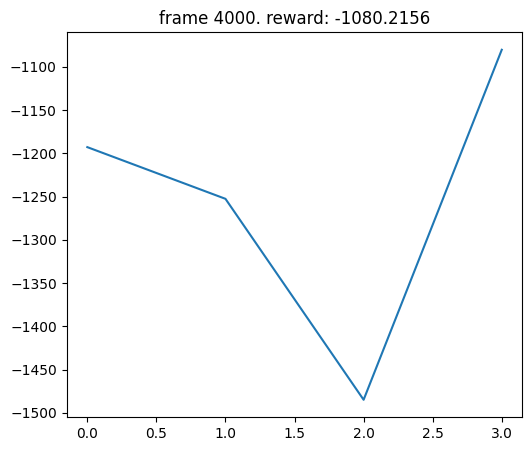

it: 4180

KeyboardInterrupt: 

In [433]:
max_frames = 30000
frame_idx  = 0
test_rewards = []

state = envs1.reset()
# create dictionary for switching easier between states of enviroments
env_states = {}     # contain state to pass when callicng act
env_step   = {}     # counter for switch
env_reward = {}     # counter for reward
early_stop = False
envs__array = { env1_name: envs1,    # name of envs
                env2_name: envs2 }

env_index = 0
while frame_idx < max_frames and not early_stop:
    print(f"\rit: {frame_idx}", end="")
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    
    for _ in range(num_steps):

        model_input = model_PC.create_model_input(state, env2_name)
        dist, value = model_PC(model_input)

        action = dist.sample()
        next_state, reward, done, _ = envs.step(action.cpu().numpy())


        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1-done).unsqueeze(1).to(device))

        #states.append(state)
        states.append(torch.FloatTensor(model_input['state'] ).to(device) )
        actions.append(action)

        state = next_state
        frame_idx += 1

        if frame_idx % 1000 == 0:
            test_reward = np.mean([test_env() for _ in range(10)])
            test_rewards.append(test_reward)
            plot(frame_idx, test_rewards)
            if test_reward > threshold_reward: early_stop = True

    #next_state = torch.FloatTensor(next_state).to(device)
    #_, next_value = model(next_state)
    model_input = model_ac.create_model_input(state, env1_name)
    _, next_value = model_ac(model_input)

    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states)
    actions   = torch.cat(actions)
    advantage = returns - values

    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)

In [ ]:
env = gym.make(env_name, render_mode='human')
test_env(vis=True)

In [ ]:
test_reward = np.mean([test_env() for _ in range(10)])
test_rewards.append(test_reward)

<h1>Saving trajectories for GAIL</h1>

In [ ]:
from itertools import count

max_expert_num = 50000
num_steps = 0
expert_traj = []

for i_episode in count():
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        expert_traj.append(np.hstack([state, action]))
        num_steps += 1

    print("episode:", i_episode, "reward:", total_reward)

    if num_steps >= max_expert_num:
        break

expert_traj = np.stack(expert_traj)
print()
print(expert_traj.shape)
print()
np.save("expert_traj.npy", expert_traj)